### Installation

In [1]:
!pip install beautifulsoup4
!pip install requests


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
from bs4 import BeautifulSoup as bs


In [3]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'
}
url = "https://www.booking.com/searchresults.en-gb.html?ss=Milan&ssne=Milan&ssne_untouched=Milan&highlighted_hotels=9813567&efdco=1&label=gog235jc-1DCAsocUIWNTAtcGFwaW5pYW5vLWFwYXJ0bWVudEgzWANoSIgBAZgBCbgBF8gBDNgBA-gBAYgCAagCA7gC0aGwtwbAAgHSAiQ4MGQwNTZmZS1mNjdhLTQ5OGMtYTlmYi1hY2U4MjcwYmI2OGXYAgTgAgE&sid=c93278ebe5554bec69805941eb4a6f66&aid=356980&lang=en-gb&sb=1&src_elem=sb&src=searchresults&dest_id=-121726&dest_type=city&checkin=2024-12-01&checkout=2024-12-03&group_adults=30&no_rooms=1&group_children=1&age=0"
r = requests.get(url, headers=headers)

if r.status_code == 200:
    print('Success')
elif r.status_code == 404:
    print('Not Found')



Success


In [14]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
import time

driver = webdriver.Chrome(service =Service("/snap/bin/chromium.chromedriver"))  
driver.get(url)  

# Scroll down to load more content (auto-load/infinite scroll)
last_height = driver.execute_script("return document.body.scrollHeight")

# Scroll until we find the "Load more results" button
while True:
    try:
        # Try to find the "Load more results" button using the span text
        load_more_button = driver.find_element("xpath", '//button[.//span[text()="Load more results"]]')
        if load_more_button:
            break  
    except NoSuchElementException:
        # Scroll down to load more content
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)  
        
    # Calculate new scroll height and compare with the last height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

# Click "Load more results" button iteratively until no more results
while True:
    try:
        load_more_button = driver.find_element("xpath", '//button[.//span[text()="Load more results"]]')
        load_more_button.click()
        time.sleep(5)  
    except (NoSuchElementException, ElementNotInteractableException):
        # No more "Load more results" button
        break

    # Scrolling to load more dynamic content 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    
soup = bs(driver.page_source, "html.parser")

driver.quit()

In [15]:
hotel_name_list = []
hotel_image_list = []
hotel_price_list = []
hotel_rating_list =[]
hotel_review_score_list = []
distance_from_center_list = []
hotel_address_list = []
hotel_summary_list = []

# Function to get the address
import re

# Loop through all listings
listings = soup.find_all('div', {"data-testid": "property-card"})
for listing in listings:
    # Get name of the hotel
    name = listing.find('div', {"data-testid": "title"}).text

    # Get distance from the city center
    distance = listing.find('span', {'data-testid': 'distance'})
    
    # Filter only the numberic value not the whole text and convert to float data type
    str_distance = distance.text
    match = re.search(r'\d+(\.\d+)?', str_distance)

    f_distance = float(match.group())
    if 'm' in str_distance and 'km' not in str_distance:
        # Convert meters to kilometers
        f_distance = f_distance / 1000.0

    # Get price
    price = listing.find('span', {'data-testid': 'price-and-discounted-price'})
    if not price:
        continue
    else:
        f_price = float(price.text.replace('€', '').replace(',', '').strip())
        
    # Get review score
    rating = listing.find('div', class_="a3b8729ab1 d86cee9b25")
    review_score_div = rating.find('div', {'class': 'ac4a7896c7'})
    review_score_parent = review_score_div.text if review_score_div else ''
    review_score = float(rating.text.replace(review_score_parent, '').strip())
        

    # Get address
    hotel_url = listing.find('a', {'class': 'a83ed08757 f88a5204c2 a1ae279108 b98133fb50'})['href']
    hotel_soup = bs(requests.get(hotel_url, headers=headers).text, 'html.parser')
    address = hotel_soup.find('span', class_='hp_address_subtitle js-hp_address_subtitle jq_tooltip').text
        
    #Get 3 images of the hotel 
    h_images = []
    images = hotel_soup.find_all('img', class_='hide')
    for i in range(0, len(images)):
        h_images.append(images[i]['src'])
        if i==3:
            break
            
    # Get hotel rating 
    hotel_rating = None
    hotel_rating_div = listing.find('div', class_='b3f3c831be')
    if hotel_rating_div:
        hotel_rating = hotel_rating_div['aria-label'][0]
     
    summary = hotel_soup.find('p', {"data-testid": "property-description"}).text
    
    
    hotel_summary_list.append(summary)
    hotel_name_list.append(name) 
    hotel_image_list.append(h_images)
    hotel_price_list.append(f_price) 
    hotel_rating_list.append(hotel_rating) 
    hotel_review_score_list.append(review_score)
    distance_from_center_list.append(f_distance)
    hotel_address_list.append(address)


In [18]:
# Importing numpy to use the fillna and isna methods
import numpy as np
import pandas as pd
df = pd.DataFrame({'name': hotel_name_list, 'price (in €)': hotel_price_list, 'rating (out of 5)': hotel_rating_list,
                   'review score': hotel_review_score_list, 'distance from center (in KM)': distance_from_center_list, 
                   'address': hotel_address_list, 'images':hotel_image_list, 'summary': hotel_summary_list})

# Making copy of the original dataframe in local device for backup
# df.to_csv("bookingdotcom_with_missing_values.csv")

# Some hotel have no rating, replace the Nan values with median 
df["rating (out of 5)"] = df["rating (out of 5)"].fillna(value=np.nan)
df["rating (out of 5)"] = df["rating (out of 5)"].fillna(df["rating (out of 5)"].median())
df["rating (out of 5)"] = df["rating (out of 5)"].astype(int)

# Saving the datafram after replacing the missing values 
# df.to_csv("bookingdotcom_without_missing_values.csv")
df.head()


,name,price (in €),rating (out of 5),review score,distance from center (in KM),address,images,summary
0,Casa Brera,21356.0,5,8.8,0.40,"\nPiazzetta M Bossi No 2, Milan City Centre, 2...",[https://cf.bstatic.com/xdata/images/hotel/max...,"Casa Brera has an outdoor swimming pool, fitne..."
1,Milan Retreats,3220.0,4,9.1,2.70,\nDifferent locations in Milan Central Station...,[https://cf.bstatic.com/xdata/images/hotel/max...,Featuring air-conditioned apartments with free...
2,Dreams Hotel Residenza Gambara,3070.0,3,7.7,3.50,"\nVia Fornari 20, San Siro, 20146 Milan, Italy\n",[https://cf.bstatic.com/xdata/images/hotel/max...,Set less than a 5-minute walk from Milan Gamba...
3,Residence Milano Bicocca,2420.0,3,7.9,6.90,"\nViale Sarca 322, Bicocca - Zara, 20125 Milan...",[https://cf.bstatic.com/xdata/images/hotel/max...,Residence Milano Bicocca offers self-catering ...
4,Milan Retreats Duomo,4788.0,4,9.1,0.25,"\nDifferent locations in Milan, Milan City Cen...",[https://cf.bstatic.com/xdata/images/hotel/max...,Situated in the centre of Milan and close to s...


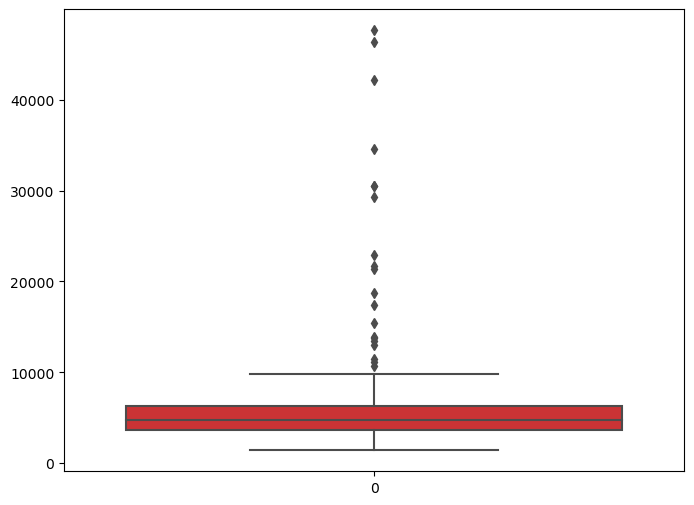

In [19]:
%matplotlib inline
import matplotlib.pyplot  as plt
import seaborn as sns

sns.set_palette("Set1")

plt.figure(figsize=(8, 6))
sns.boxplot(df['price (in €)'])
# sns.histplot(df['price (in €)'], bins=12, kde=True)
# plt.title('Price Distribution')
# plt.xlabel('price (in €)')
# plt.ylabel('Frequency')
plt.show()

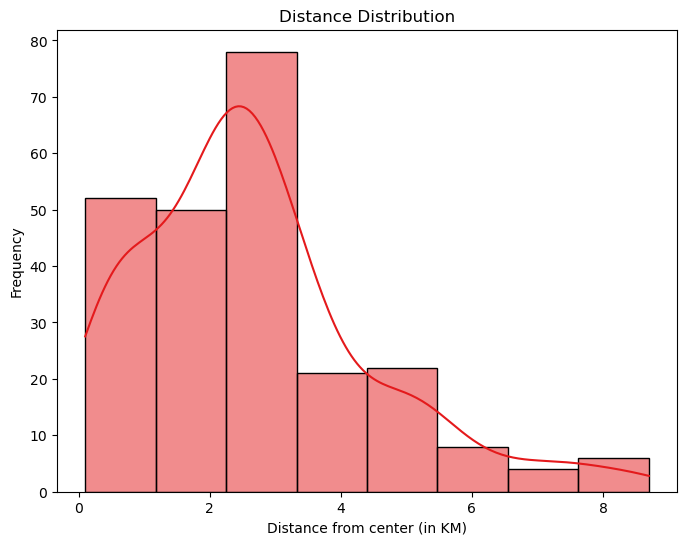

In [8]:
%matplotlib inline
import matplotlib.pyplot  as plt
import seaborn as sns

sns.set_palette("Set1")

plt.figure(figsize=(8, 6))
sns.histplot(df['distance from center (in KM)'], bins=8, kde=True)
plt.title('Distance Distribution')
plt.xlabel('Distance from center (in KM)')
plt.ylabel('Frequency')
plt.show()

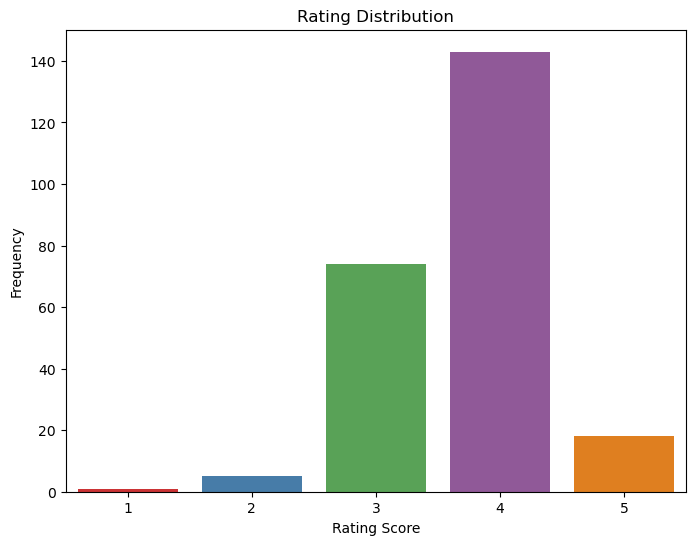

In [9]:
%matplotlib inline
import matplotlib.pyplot  as plt
import seaborn as sns

sns.set_palette("Set1")
plt.figure(figsize=(8, 6))
rating_counts = df['rating (out of 5)'].value_counts()
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title('Rating Distribution')
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.show()

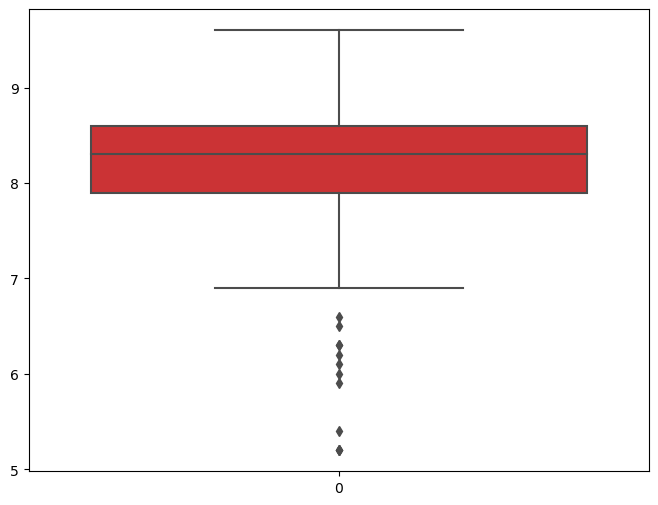

In [10]:
%matplotlib inline
import matplotlib.pyplot  as plt
import seaborn as sns

sns.set_palette("Set1")

plt.figure(figsize=(8, 6))
sns.boxplot(df['review score'])
# plt.title('Review Score Distribution')
# plt.xlabel('Review Scores')
# plt.ylabel('Frequency')
plt.show()

In [31]:
from IPython.display import Image, display, HTML

price_min = float(input("Enter lowest price value: "))
price_max = float(input("Enter highest price value: "))
distance_min = float(input("Enter minimum distance from center value (in KM): "))
distance_max = float(input("Enter maximum distance from center value (in KM): "))
review_min = float(input("Enter minimum review score value (1 - 10): "))
review_max = float(input("Enter maximum review score value (1 - 10): "))
rating_min = int(input("Enter the minimum hotel rating (out of 5) value: "))



# Filtering the DataFrame based on user input
new_df = df[(df['price (in €)'] >= price_min) & (df['price (in €)'] <= price_max) &
                 (df['distance from center (in KM)'] >= distance_min) & 
                 (df['distance from center (in KM)'] <= distance_max) &
                 (df['review score'] >= review_min) & (df['review score'] <= review_max) &
                 (df['rating (out of 5)'].astype('int') >= rating_min)
           ]

def sort_by(input_value):
    if input_value == 1:
        return "price (in €)"
    if input_value == 2:
        return "distance from center (in KM)"
    if input_value == 3:
        return "review score"
    if input_value == 4:
        return "rating (out of 5)"
    else:
        return "price (in €)"
        
input_value = float(input("How do you want it to be sorted by?: \n Enter 1 to sort it by price \n Enter 2 to sort it by distance from center \n Enter 3 to sort it by review score \n Enter 4 to sort it by rating \n"))

# Sorting by price and distance in a ascending order but
# sort them in descending order if sorted by review score 
asc = True
if input_value == 3 or input_value == 4:
    asc = False
sorted_df = new_df.sort_values(by=sort_by(input_value), ascending=asc)

# Output the first sorted 10 hotels 
result = sorted_df.head(10)

print(f"\n======================= RESULTS sorted by {sort_by(input_value)}=========================\n")


# Checking if the search parameter doesn't hold true
def display_hotel_details(row):
  image = None
  if row['images']:
        image = row['images'][0]
  html = f"""
  <div style="display: flex; align-items: center; margin-bottom: 20px;">
          <img src="{image}" alt="{row['name']}" style="width: 200px; height: auto; margin-right: 20px;">
      <div>
          <h4 style="font-size:18px"> <strong>{row['name']}</strong></h4><br>
          <i><strong>Price (in €):</strong></i> {row['price (in €)']}<br>
          <i><strong>Distance from center (in KM):</strong></i> {row['distance from center (in KM)']}<br>
          <i><strong>Review Score:</strong></i> {row['review score']}<br>
          <i><strong>Rating (out of 5):</strong></i> {row['rating (out of 5)']}<br>
          <i><strong>Address:</strong></i> {row['address']}<br>
      </div>
  </div>
  """
  display(HTML(html))

    
# Display three more pictures of the hotel when a user wants to see details of a particular hotel    
def display_more_hotel_pictures(row):
    print("Here some more photos of the hotel :)")
    html = """
    <div style="display: flex; align-items: center; margin-bottom: 20px;">
    """
    for i in range(1, len(row['images'])):
        html += f"""
        <div style="margin-right: 20px;">
            <img src="{row['images'][i]}" alt="{row['name']}" style="width: 200px; height: auto;">
        </div>
        """
    html += """
    </div>
    """
    
    html += f"""
    <div>
        <p style="font-size: 16px; color: #555;">{row['summary']}</p>
    </div>
    """
    
    display(HTML(html))

# Check result is not empty        
if result.empty:
  print("Nothing to display :)")
else:
  # Call a function to display the hotel details of  
  for index, row in result.iterrows():
      display_hotel_details(row)
  print("\n")
  hotel_name = input("Enter full name of the hotel to see more details: ")
  hotel = df[df['name']==hotel_name]
    
  # Change the dataframe to series  
  if not hotel.empty:
    hotel = hotel.iloc[0,:]
    print("\n\n +++++++++++++++++++++++ More detailed info +++++++++++++++++++")
    display_hotel_details(hotel)
    display_more_hotel_pictures(hotel)
  else: 
    print("\n Try another name or please write the full name of the hotel")
    

Enter lowest price value: 0
Enter highest price value: 10000
Enter minimum distance from center value (in KM): 0.2
Enter maximum distance from center value (in KM): 10
Enter minimum review score value (1 - 10): 1
Enter maximum review score value (1 - 10): 10
Enter the minimum hotel rating (out of 5) value: 4
How do you want it to be sorted by?: 
 Enter 1 to sort it by price 
 Enter 2 to sort it by distance from center 
 Enter 3 to sort it by review score 
 Enter 4 to sort it by rating 
2

======================= RESULTS sorted by distance from center (in KM)=========================





Enter full name of the hotel to see more details: Heart Milan Apartments Duomo District


 +++++++++++++++++++++++ More detailed info +++++++++++++++++++


Here some more photos of the hotel :)
